# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [1]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal 
from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [4]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


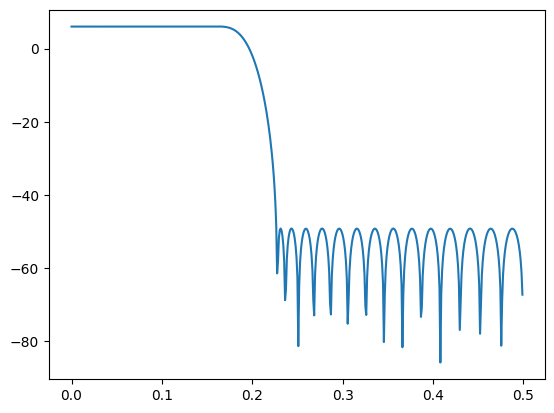

In [5]:
L = 2
M = 3
nu_c = min(1/(2*L), 1/(2*M))
nu_a = nu_c + 0.06

h = scipy.signal.remez(50 ,[0,nu_c,nu_a,.5],[L, 0])


freq, response = scipy.signal.freqz(h)
ampl = 20*np.log10(np.abs(response))

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(freq/(2*np.pi), ampl)  # freq in Hz
plt.show()


In [6]:
play = False
if play :
    play_sound(sound) 

In [7]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [8]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

In [11]:
import time


deb=time.time()

x_up=[0 for i in range(2*(len(x)))]
for i in range (len(x)):
    x_up[2*i]=x[i]

x_filt=scipy.signal.lfilter(h, [1,0], x_up, axis=-1, zi=None)

x_fin=[]


for i in range (len(x_filt)):
    if i%3==0:
        x_fin.append(x_filt[i])

print(time.time()-deb)
L=2
M=3

timestep_new = 1/float(Fs*(L/M))
times_new = np.arange(len(x_fin))*timestep_new

1.2356255054473877


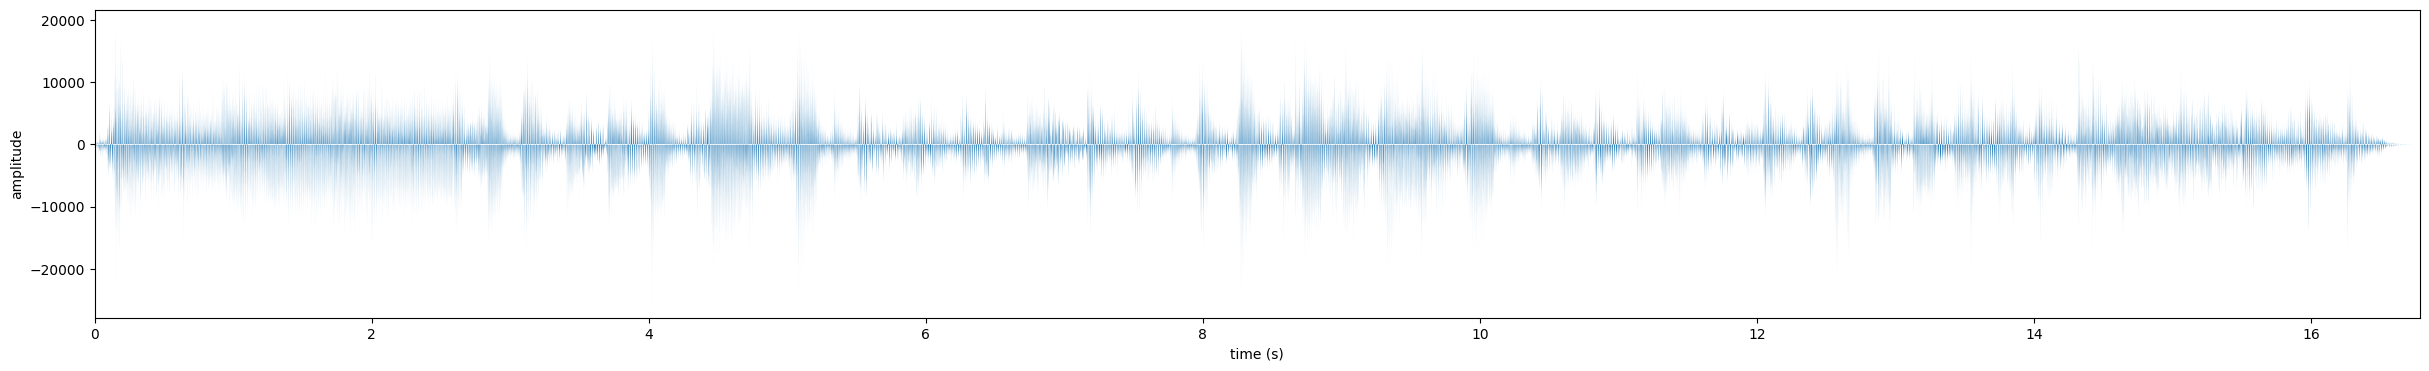

In [12]:
plot_sound(x, times)

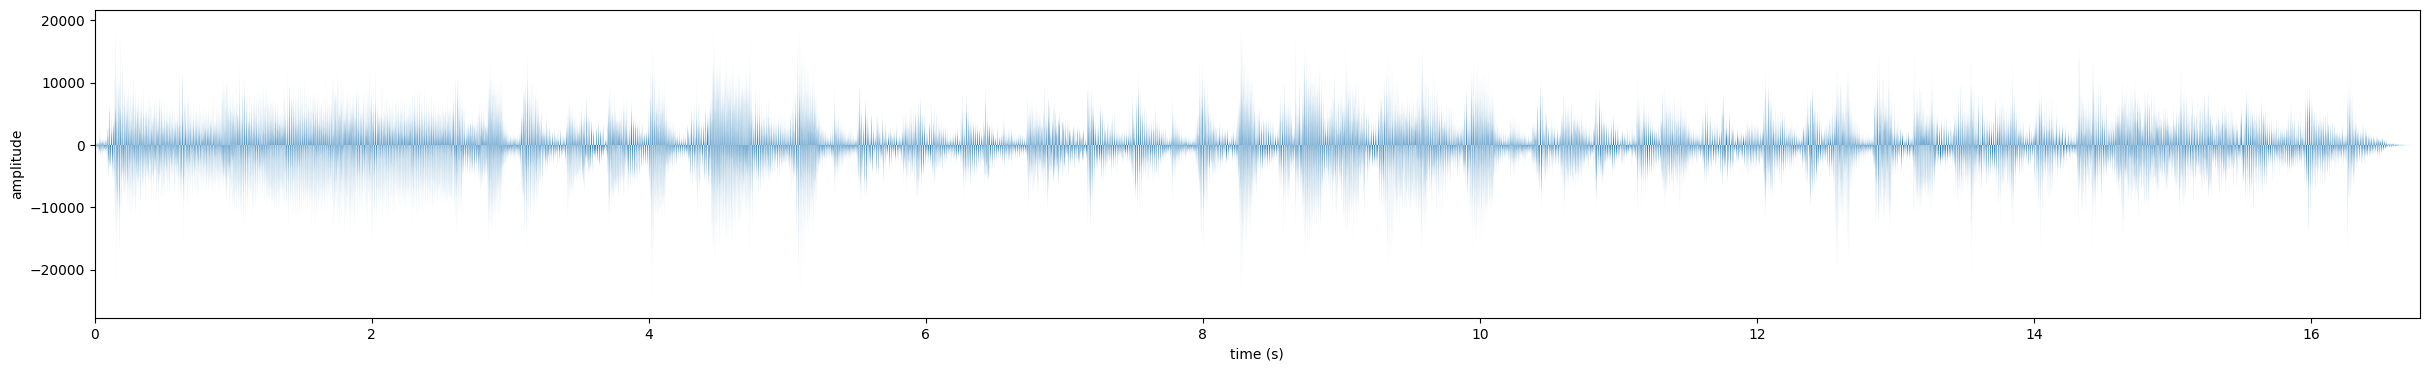

In [13]:
plot_sound(x_fin, times_new)

In [14]:
write('new_caravan.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file


In [16]:
# Fonctions utiles

def décalage(x,n):
    if n>0:
        x1=n*[0]+x[0:len(x)-n]
    else:
        x1=x[(-n):len(x)]+(-n)*[0]
    return x1

def décimation(x,n):
    x1=[]
    for i in range (len(x)):
        if i%n==0:
            x1.append(x[i])
    return x1

def upsample(x,n):
    x1=[]
    for i in range (len(x)):
        x1.append(x[i])
        for j in range (n-1):
            x1.append(0)
    return x1

def filtre_RE(n,m,h):
    #n est le décalage recherché au départ, m est le pas de la décimation du filtre 
    #Attention: si filtre R, le décalage est inversé (si décimation de 2, pour obtenir R0, il faut prendre n=1)
    x_1=[]
    for i in range (len(h)):
        if i%m==n:
            x_1.append(h[i])
    return x_1

def deca_decim(x,x_z_boucle):
    for i in range(len(x)):
        if i%3==0:
            x_z_boucle[0].append(x[i])
        elif i%3==1:
            x_z_boucle[1].append(x[i])
        else:
            x_z_boucle[2].append(x[i])
    return x_z_boucle

def sum(x_z_boucle):
    x_z_boucle_sum=[]
    min_len=min(len(x_z_boucle[0]),len(x_z_boucle[1]),len(x_z_boucle[2]))
    for i in range(min_len):
        x_z_boucle_sum.append(x_z_boucle[0][i]+x_z_boucle[1][i]+x_z_boucle[2][i])
    return x_z_boucle_sum

In [17]:
#Création des filtres R et E

filtre=[[],[],[],
        [],[],[]]
for i in range (len(h)):
    if i%6==0:
        filtre[3].append(h[i])
    elif i%6==1:
        filtre[0].append(h[i])
    elif i%6==2:
        filtre[4].append(h[i])
    elif i%6==3:
        filtre[1].append(h[i])
    elif i%6==4:
        filtre[5].append(h[i])
    else:
        filtre[2].append(h[i])

In [18]:
deb=time.time()

#BOUCLE 1

x_z_boucle1=[[],[],[]]
x_z_boucle2=[[],[],[]]

    
x_z=décalage(x,1)
x_z_boucle1=deca_decim(x_z,x_z_boucle1)
for i in range(M):
    x_z_boucle1[i]=scipy.signal.lfilter(filtre[i], [1,0], x_z_boucle1[i], axis=-1, zi=None)
x1_fin=sum(x_z_boucle1)
x_boucle1=upsample(x1_fin,2)
x_boucle1=décalage(x_boucle1,-1)

#BOUCLE 2

x_z_boucle2=deca_decim(x,x_z_boucle2)
for i in range(M):
    x_z_boucle2[i]=scipy.signal.lfilter(filtre[3+i], [1,0], x_z_boucle2[i], axis=-1, zi=None)

x2_fin=sum(x_z_boucle2)
x_boucle2=upsample(x2_fin,2)
x_fin=[x_boucle2[i]+x_boucle2[i] for i in range(min(len(x_boucle2),len(x_boucle1)))]



print(time.time()-deb)


1.9465398788452148


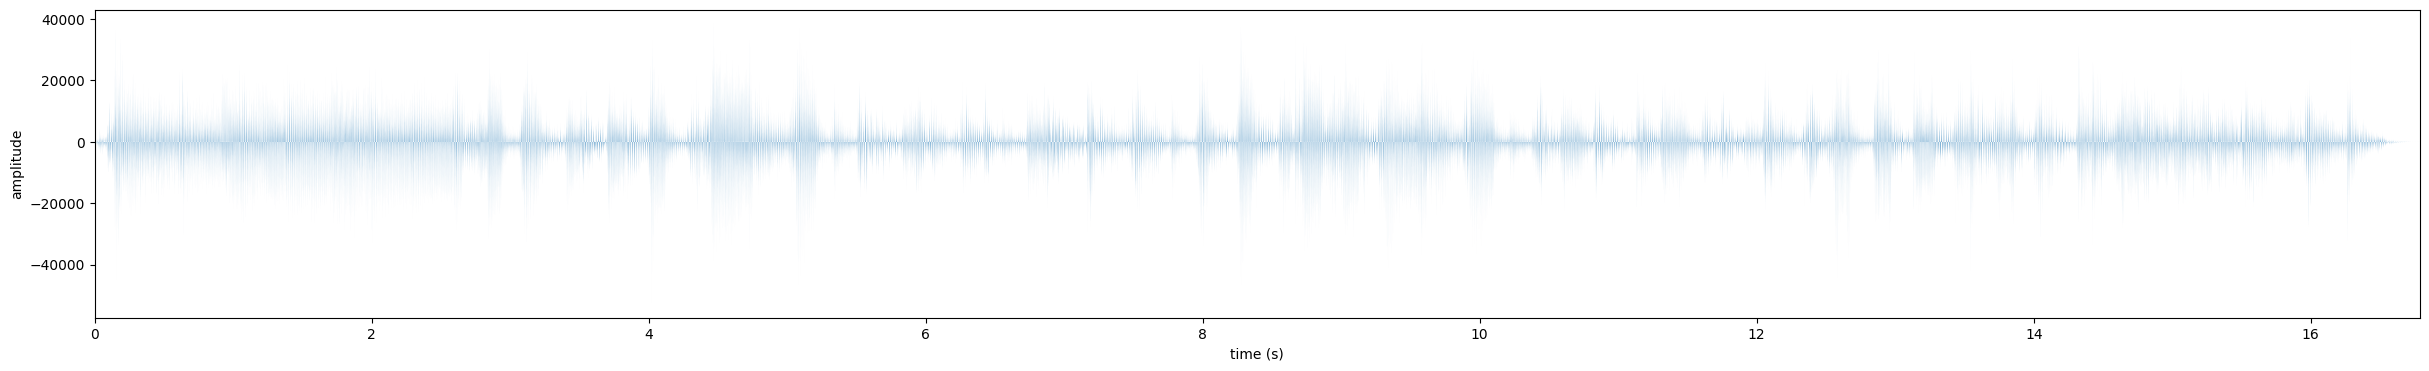

In [19]:
timestep_new = 1/float(Fs*(L/M))
times_new = np.arange(len(x_fin))*timestep_new
plot_sound(x_fin, times_new)

## Signal analysis with the STFT

In [20]:
N = x.shape[0] # % longueur du signal
Nw = 512
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 512 # ordre de la tfd
L = M/2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

In [21]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

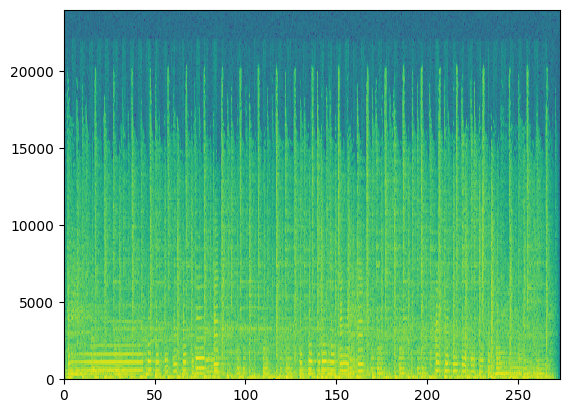

In [23]:
L = int(L)
if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])
    

C:\Users\maeli\AppData\Local\Temp\ipykernel_28340\135814518.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.plot(frequences_shifted,20*np.log10(np.abs(W_shifted)))


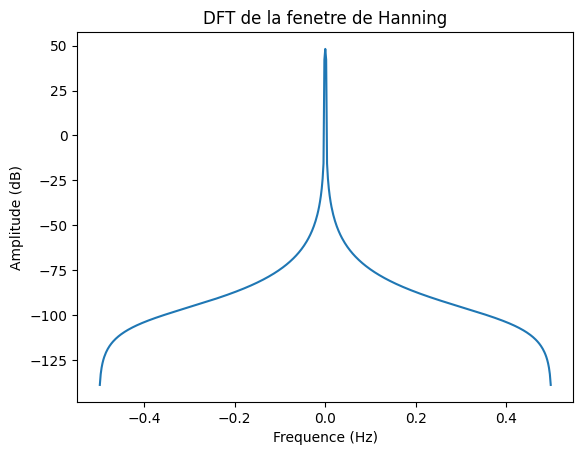

In [24]:
# Affichage DFT de la fenêtre

W = np.fft.fft(w,Nw)
W_shifted = np.fft.fftshift(W)
frequences = np.fft.fftfreq(Nw)
frequences_shifted = np.fft.fftshift(frequences)
plt.figure()
plt.plot(frequences_shifted,20*np.log10(np.abs(W_shifted)))
plt.xlabel('Frequence (Hz)')
plt.ylabel('Amplitude (dB)')
plt.title('DFT de la fenetre de Hanning')
plt.show()


## Overlap-add reconstruction

In [25]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

### ** Question 2 **
Après changement de l'expression de la somme, on obtient la convolution suivante :
$ \sum{$n \in mathbb{Z}$} (x(n)*w(n-b)*e**(-2*j*pi*lambda*(n-b)))*e**(-2*j*pi*lambda*b) $
